## Introduction
### AcquireX analysis scripts to evaluate feature distribution, feature mapping, background ion detection and other useful plots

In [1]:
# Load the packages/source scripts required to read XML files and process the data.
library(XML)
library(methods)
library(data.table)
source('AcquireXFunctions.R')

### Load xml file and convert it to a data table in R

In [2]:
#this is the inclusion list xml file (must be in the working directory or the Jupyter directory)
xml = 'InclusionList.xml'

#Convert the input xml file to a data table.
d = data.table(xmlToDataFrame(xml))

#first row is empty 
dt = d[2:nrow(d),]

#xml data are strings so convert to numeric
dt$Mass_x0020__x005B_m_x002F_z_x005D_ = as.numeric(dt$Mass_x0020__x005B_m_x002F_z_x005D_)
dt$Intensity = as.numeric(dt$Intensity)
dt$Start_x0020__x005B_min_x005D_ = as.numeric(dt$Start_x0020__x005B_min_x005D_)
dt$End_x0020__x005B_min_x005D_ = as.numeric(dt$End_x0020__x005B_min_x005D_)

#summary stats
summary(dt)

   element          Mass_x0020__x005B_m_x002F_z_x005D_   Polarity        
 Length:38187       Min.   :150.0                      Length:38187      
 Class :character   1st Qu.:380.3                      Class :character  
 Mode  :character   Median :496.3                      Mode  :character  
                    Mean   :518.8                                        
                    3rd Qu.:639.2                                        
                    Max.   :999.1                                        
   Intensity         Start_x0020__x005B_min_x005D_ End_x0020__x005B_min_x005D_
 Min.   :5.000e+04   Min.   : 0.000                Min.   : 0.1534            
 1st Qu.:1.611e+05   1st Qu.: 4.127                1st Qu.: 4.4269            
 Median :3.455e+05   Median : 6.542                Median : 6.8416            
 Mean   :3.083e+06   Mean   : 6.933                Mean   : 7.2328            
 3rd Qu.:9.677e+05   3rd Qu.:10.064                3rd Qu.:10.3640            
 Max.   

### Print first 5 rows of the inclusion list table

In [3]:
dt[1:5,]

element,Mass_x0020__x005B_m_x002F_z_x005D_,Polarity,Intensity,Start_x0020__x005B_min_x005D_,End_x0020__x005B_min_x005D_
NA,150.0259,Positive,80912720,9.6897605,9.9897605
NA,150.0262,Positive,15036221,12.4291090,12.7291090
NA,150.0264,Positive,23258225,9.5715800,9.8715800
NA,150.0581,Positive,1619148,0.2858179,0.5858179
NA,150.0628,Positive,938172,7.9672331,8.2672331


### Plot 4 plots in the same window. Features are filtered based on the RT bin and intensities

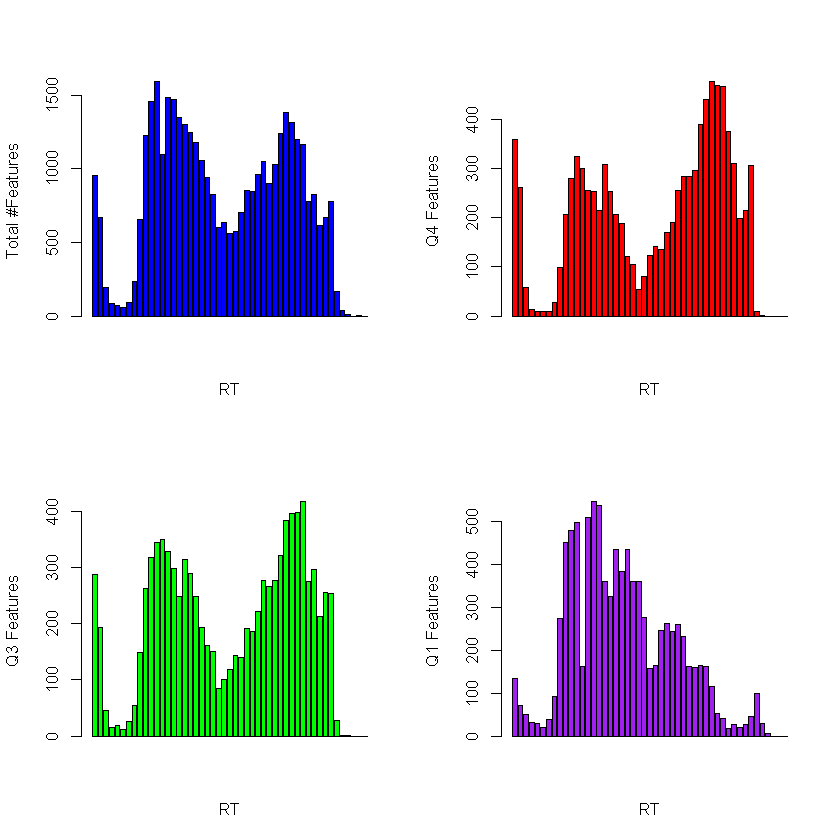

In [4]:
#Plot the features as a fucntion of quartiles and bins
par(mfrow=c(2,2))

t <- GetFeatureDistribution(dt,.3)
barplot(t$Features,ylab = 'Total #Features',xlab = 'RT', col = 'blue')

test <- dt[which(dt$Intensity > 9.677e5)]
t <- GetFeatureDistribution(test,.3)
barplot(t$Features,ylab = 'Q4 Features',xlab = 'RT', col = 'red')

test <- dt[which(dt$Intensity < 9.677e5 & dt$Intensity > median(dt$Intensity))]
t <- GetFeatureDistribution(test,.3)
barplot(t$Features,ylab = 'Q3 Features',xlab = 'RT', col = 'green')

test <- dt[which(dt$Intensity < 1.611e5)]
t <- GetFeatureDistribution(test,.3)
barplot(t$Features,ylab = 'Q1 Features',xlab = 'RT', col = 'purple')

## Library Analysis Functions

In [21]:
ComputeMassError <- function(theoreticalMass,experimentalMass){
  return (((experimentalMass - theoreticalMass) / theoreticalMass) * 1e6);
}

Process <- function(scans,targets){
  
  #create result table
  resTable <- data.table(
    Compound = character(),
    Mz = numeric(),
    RT = numeric(),
    ScanNumber = numeric())
  
  for(i in 1:nrow(targets)){
    
    for(j in 1:nrow(scans)){

      err = ComputeMassError(targets[i]$X.M.H..,scans[j]$PrecursorMz)
      
      # if the error is < 10 ppm then add to the list
      if(abs(err) < 5){
       
         t <- data.table(
          Compound =as.character(targets[i]$metabolite),
          Mz = scans[j]$PrecursorMz,
          RT = scans[j]$RetentioTime,
          ScanNumber =as.numeric(scans[j]$ScanNumber))
        
        if(nrow(resTable) == 0){
          resTable = t
          break
        }
        else{
          resTable <- rbind(resTable,t)
          break
        }
      }
    }
  }
  return (resTable)
}


### Convert raw file to JSON and process

In [6]:
library(jsonlite)
library(data.table)


#convert raw file to json
system("C:/R/Jupyter/filereader/Thermo.RawFileExtractor.Console.exe  -d C:/R/Jupyter/data -o 2")
json <- "C:/R/Jupyter/data/StandardsID4thQuartile.json"

#target files
targets <- "C:/R/Jupyter/libtargets.csv"

#read json data
scans <- data.table(fromJSON(json))
targets <- data.table(read.csv(targets))

#set as numeric data
targets$X.M.H.. <- as.numeric(targets$X.M.H..)
targets$RT..min. <- as.numeric(targets$RT..min.)

In [7]:
targets

metabolite,class,Chemical.Formula,RT..min.,X.M.H..
ornithine,aminoacid,C5H12N2O2,0.77,133.0972
glycine,aminoacid,C2H5NO2,0.83,76.0393
aspartic acid,aminoacid,C4H7NO4,0.85,134.0448
creatinine,aminoacid derivative,C4H7N3O,0.90,114.0662
uracil,nucleobase,C4H4N2O2,1.28,113.0346
methionine,aminoacid,C5H11NO2S,1.44,150.0583
nicotinamide,vitamin,C6H6N2O,1.63,123.0552
isoleucine,aminoacid,C6H13NO2,2.19,132.1019
leucine,aminoacid,C6H13NO2,2.33,132.1019
adenosine,nucleoside,C10H13N5O4,2.49,268.1040


### Compounds Detected

In [20]:

r <- Process(scans,targets)
r

Compound,Mz,RT,ScanNumber
ornithine,133.0972,0.77,390
glycine,76.0393,0.83,420
creatinine,114.0662,0.90,450
uracil,113.0346,1.28,605
methionine,150.0583,1.44,685
nicotinamide,123.0552,1.63,713
isoleucine,132.1019,2.19,829
leucine,132.1019,2.33,829
adenosine,268.1040,2.49,801
phenylalanine,166.0863,3.46,940


In [18]:
nrow(r)

[1] 16